# SC1015 Lab 8
## Introduction
Modern enterprises face decision-making challenges of exponential complexity [1]. Three key drivers include: <br>
(1) the big data revolution increasing decision variables significantly <br>
(2) interdependent real-world systems <br>
(3) objectives with competing priorities [2, 3]. <br>

The team aims to explore combinatorial optimization through a simplified version of the Traffic Jam game. In this environment, an AI agent formulates an optimal path to a goal that minimizes the total number of moves. This is done by mapping board states to moves taken and minimizing vehicle movement.
These same principles scale remarkably to global shipping optimization [4], where:
•	Each port call represents a "move" in the Traffic Jam analogy.
•	Fuel costs and emissions act as the "reward function" to optimize.
•	Weather patterns and port schedules create the "constraint network."
With AI-driven optimization algorithms, shipping companies can find the most efficient routing strategies to improve operational costs, reduce emissions, and ensure timely deliveries. This demonstrates how principles learned in simpler environments can be translated to real-world applications.

## Members
Name: Kee Chong Wei |  Matriculation Number: U2320846D <br>
Name: Jiang Zong Zhe | Matriculation Number: U2322460F <br>
Name: Chew Jin Cheng | Matriculation Number: U2321537J <br>

## References
[1] Berutich Lindquist, J. M. (2017). Robust optimization of algorithmic trading systems. <br>
[2] Mukelabai, M., Nešić, D., Maro, S., Berger, T., & Steghöfer, J. P. (2018, September). Tackling combinatorial explosion: a study of industrial needs and practices for analyzing highly configurable systems. In Proceedings of the 33rd acm/ieee international conference on automated software engineering (pp. 155-166). <br>
[3] Surana, A., Kumara*, S., Greaves, M., & Raghavan, U. N. (2005). Supply-chain networks: a complex adaptive systems perspective. International Journal of Production Research, 43(20), 4235-4265. <br>
[4] Walther, L., Rizvanolli, A., Wendebourg, M., & Jahn, C. (2016). Modeling and optimization algorithms in ship weather routing. International journal of e-navigation and maritime economy, 4, 31-45.


In [40]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from collections import defaultdict, deque
import heapq
import itertools
import timeit

## Visualising Problem Space

1. Define the map in the form of an object mazeGrid
2. Define the different types of possible objects occupying each square
3. Choose a letter to represent each object in code format
4. Choose a unicode symbol to represent each object in printed output

In [3]:
# begin by visualising problem space

def printProblemState(mazeGrid):
    ''' Display the maze corresponding to a binary grid
        Input : 2D NumPy array with 'W', 'O','T','G','E' as elements
        Output : Simple print of the corresponding maze
    '''
    (height, width) = mazeGrid.shape
    
    print()
    for i in range(height):
        for j in range(width):
            if mazeGrid[i,j] == 'W': # walls
                print("\u2b1b", end = " ")   # use some other character if the unicode does not print properly
            elif mazeGrid[i,j] == ' ': # empty spaces
                print("\u2b1c", end = " ")
            elif mazeGrid[i,j] == 'G': # goal
                print("\u2690", end=" ")
            elif mazeGrid[i,j] == 'O': # obstacles
                print("\u2780", end= " ")
            elif mazeGrid[i,j] == 'T': # target vehicle
                print("\u26f4", end=" ")
        print()

mazeTuple = (('W','W','W','W'),
            ('T','O','O','G'),
            ('W','O',' ',' '),
            ('W','W','W','W'))
# Convert to a NumPy array
maze = np.array(mazeTuple)

# Print the maze using helper functions
print("Maze of dimensions", maze.shape)
printProblemState(maze)

Maze of dimensions (4, 4)

⬛ ⬛ ⬛ ⬛ 
⛴ ➀ ➀ ⚐ 
⬛ ➀ ⬜ ⬜ 
⬛ ⬛ ⬛ ⬛ 


link to unicode symbols: https://symbl.cc/en/unicode-table/#miscellaneous-symbols-and-arrows

## Defining Helper Functions

1. Helper functions for constructing State Graph
2. Helper functions for manipulating mazeGrid, the problem map

In [5]:
# Set goal_position once, independent of the grid.
goal_position = (1, 3) 

# define a node class 
class Node:
    def __init__(self, grid, move=None, parent=None):
        self.grid = grid          # grid is a tuple of tuples representing the board
        self.move = move          # a tuple: (piece, from_position, to_position), this is used for easier visualisation of moves taken during search
        self.parent = parent      # pointer to the previous Node (None for the root), this is used to reconstruct the solution path

# used to find a position of a specified piece on the grid
def find_positions(grid, piece): 
    positions = []
    for i, row in enumerate(grid):
        for j, cell in enumerate(row):
            if cell == piece:
                positions.append((i, j))
    return positions

# used to find position of target vehicle
def get_target_position(grid):
    positions = find_positions(grid, 'T')
    return positions[0] if positions else None

# calculation of manhattan distance
def manhattan_distance(a, b):
    return abs(a[0] - b[0]) + abs(a[1] - b[1])

# used to find manhattan distance between target and goal for a given grid arrangement
def heuristic(grid):
    t_pos = get_target_position(grid)
    return manhattan_distance(t_pos, goal_position) if t_pos else float('inf')

# used to check if target is on goal position
def is_goal(grid):
    # Goal is reached when T occupies the same cell as G.
    return get_target_position(grid) == goal_position

# function to move an obstacle or vehicle
def move_piece(grid, pos, direction):
    rows, cols = len(grid), len(grid[0])
    grid_list = [list(row) for row in grid]
    x, y = pos
    dx, dy = direction
    new_x, new_y = x + dx, y + dy

    # Check boundaries.
    if not (0 <= new_x < rows and 0 <= new_y < cols):
        return None

    target_piece = grid_list[x][y]
    destination = grid_list[new_x][new_y]

    if target_piece == 'T':
        # Allow T to move into an empty space or the goal.
        if destination in [' ', 'G']:
            grid_list[new_x][new_y] = 'T'
            # Restore the goal if T moves away from it.
            grid_list[x][y] = 'G' if grid_list[x][y] == 'T' and (x, y) == goal_position else ' '
        else:
            return None
    else:
        # For obstacles, allow only movement into empty space.
        if destination == ' ':
            grid_list[new_x][new_y] = target_piece
            grid_list[x][y] = ' '
        else:
            return None

    return tuple(tuple(row) for row in grid_list)

def get_solution_path(node):
    path = []
    while node:
        path.append(node)
        node = node.parent
    path.reverse()
    return path

# returns grid configuration after each move, for building state space tree
def get_successors(grid):
    successors = []
    # Convert grid to a mutable structure
    grid_list = [list(row) for row in grid]

    # For each cell in the grid:
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if grid[x][y] in ('T', 'O'):
                # Try moving up, down, left, right
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    new_grid = move_piece(grid, (x, y), (dx, dy))
                    if new_grid is not None:
                        successors.append(new_grid)
    return successors

# returns grid configuration and move taken to reach grid configuration, for search algorithms to backtrack
def get_successor_nodes(node):
    children = []
    grid = node.grid
    # Define the four possible directions: up, down, left, right.
    directions = [(-1, 0), (1, 0), (0, -1), (0, 1)]
    for x in range(len(grid)):
        for y in range(len(grid[0])):
            if grid[x][y] in ('T', 'O'):
                for dx, dy in directions:
                    new_grid = move_piece(grid, (x, y), (dx, dy))
                    if new_grid is not None:
                        # Record the move as: (piece moved, from_position, to_position)
                        move = (grid[x][y], (x, y), (x + dx, y + dy))
                        child_node = Node(new_grid, move, node)
                        children.append(child_node)
    return children


def build_state_graph(start_grid):
    graph = defaultdict(list)
    visited = set()
    queue = deque([start_grid])
    visited.add(start_grid)

    while queue:
        current = queue.popleft()
        # Get all possible next states from current
        next_states = get_successors(current)
        for nxt in next_states:
            graph[current].append(nxt)
            if nxt not in visited:
                visited.add(nxt)
                queue.append(nxt)
    return graph



## Printing State Graph

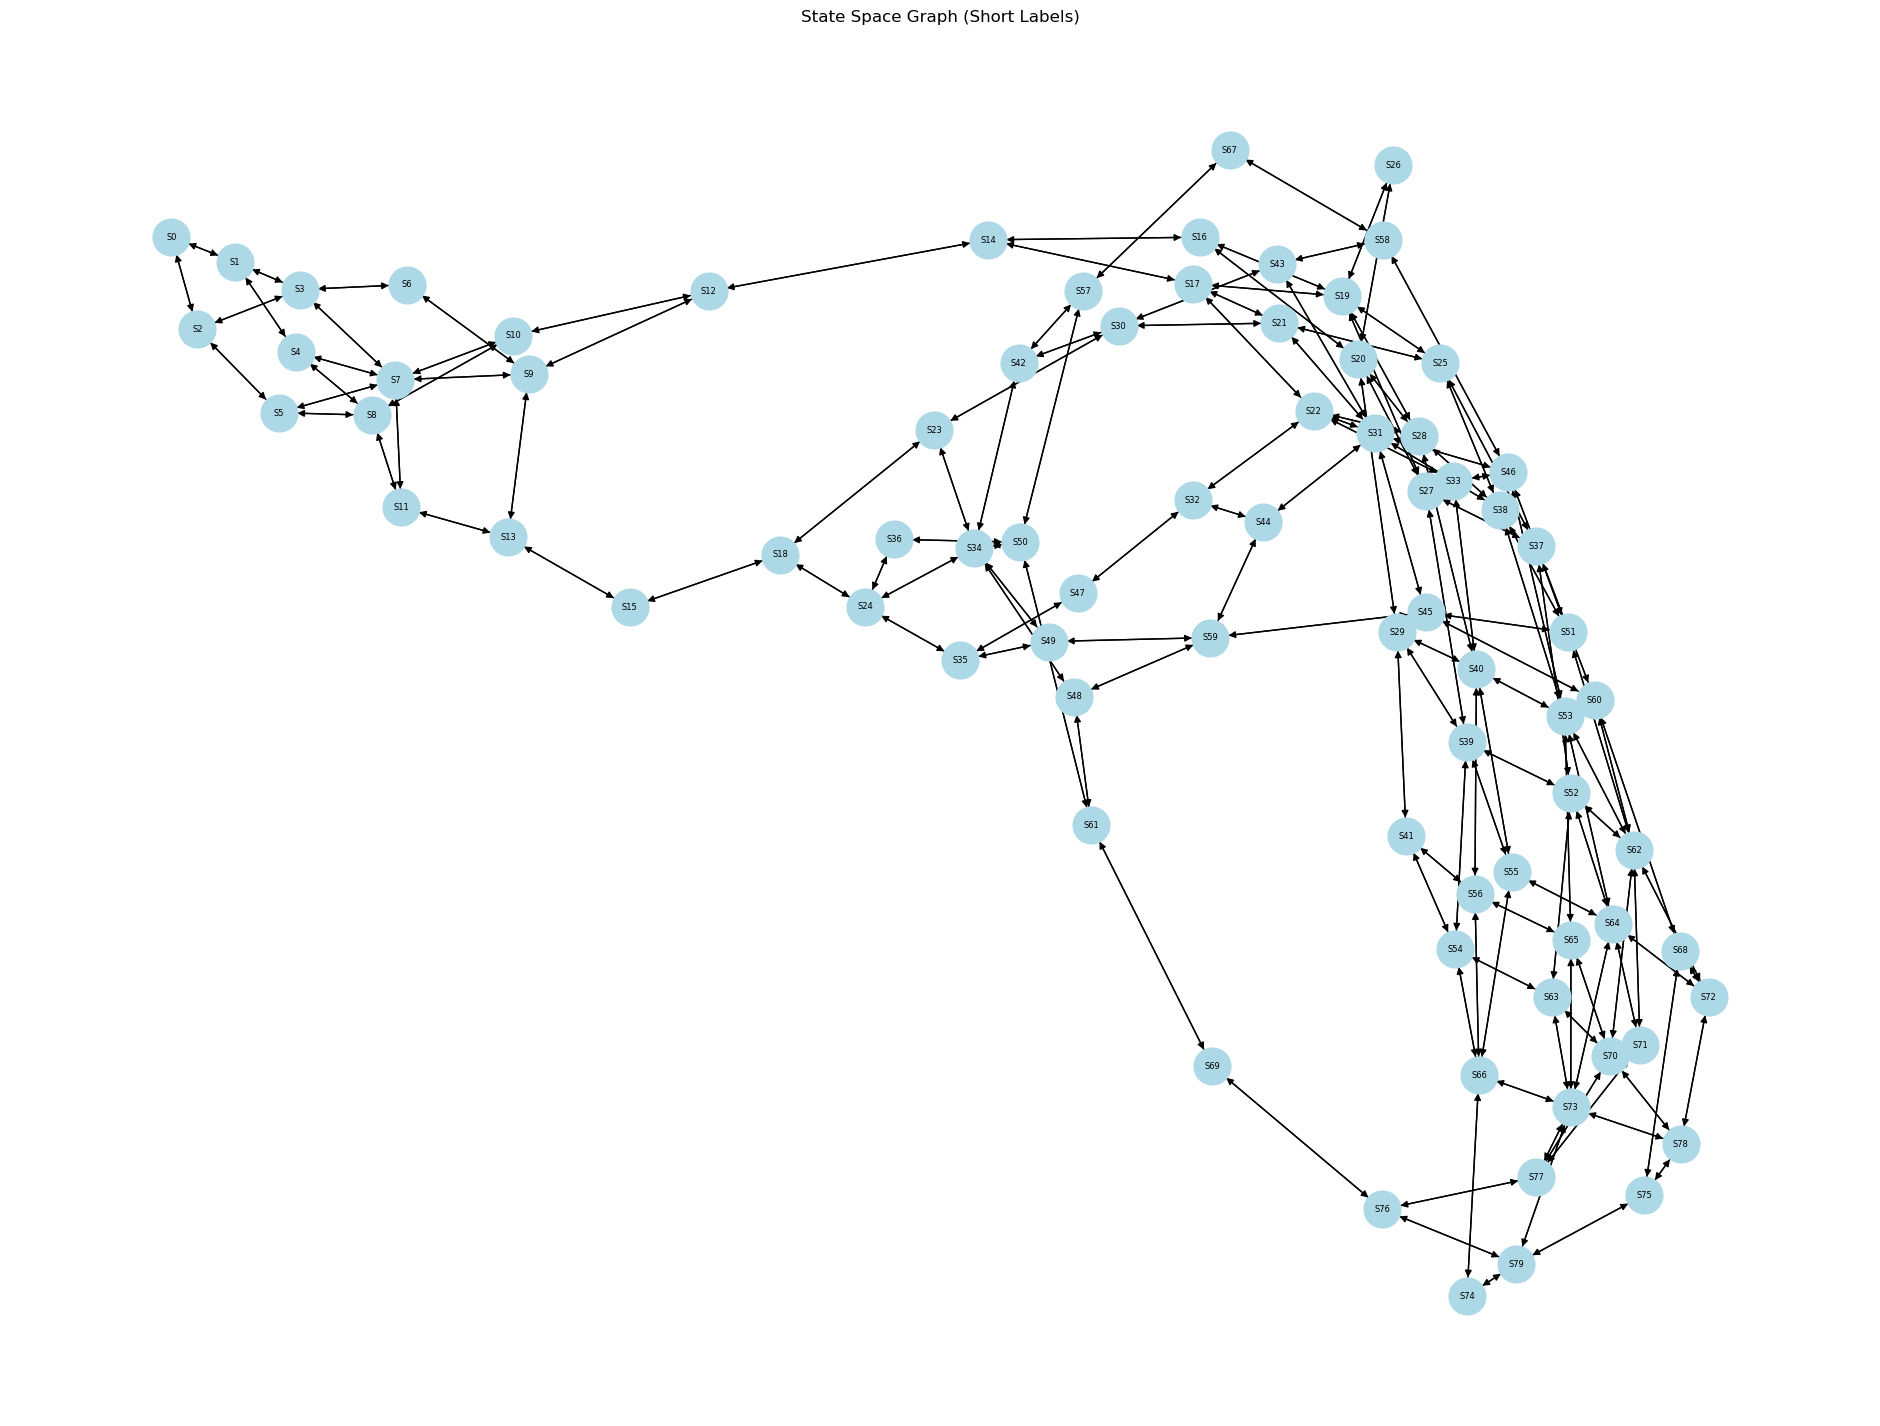

In [6]:
def visualize_state_graph(graph):
    # 1) Create a mapping from state -> short ID
    state_to_id = {}
    id_to_state = {}
    idx = 0

    for state in graph.keys():
        state_to_id[state] = f"S{idx}"
        id_to_state[f"S{idx}"] = state
        idx += 1

    # Also map neighbors
    for state, neighbors in graph.items():
        for nb in neighbors:
            if nb not in state_to_id:
                state_to_id[nb] = f"S{idx}"
                id_to_state[f"S{idx}"] = nb
                idx += 1

    # 2) Build the NetworkX graph
    G = nx.DiGraph()
    for state, neighbors in graph.items():
        state_id = state_to_id[state]
        G.add_node(state_id)
        for nb in neighbors:
            nb_id = state_to_id[nb]
            G.add_node(nb_id)
            G.add_edge(state_id, nb_id)

    # 3) Draw with smaller node size and font
    pos = nx.spring_layout(G, seed=42)
    plt.figure(figsize=(24, 18))
    nx.draw_networkx(
        G,
        pos,
        with_labels=True,
        node_size=700,
        node_color="lightblue",
        arrows=True,
        font_size=6
    )
    plt.title("State Space Graph (Short Labels)")
    plt.axis("off")
    plt.show()
graph = build_state_graph(mazeTuple)
visualize_state_graph(graph)

BFS
Approach: Explore all nodes at the present depth before moving to nodes at the next depth level, using a queue data structure

This solution is complete and guarantees finding the shortest path.

In [46]:
%%timeit -n 100 -r 3

# Breadth-First Search
def bfs_search_nodes(initial_grid, goal_test):
    root = Node(initial_grid)
    queue = deque([root])
    visited = set([str(initial_grid)])
    
    while queue:
        current = queue.popleft()
        if goal_test(current.grid):
            return current  # Return the goal node.
        for child in get_successor_nodes(current):
            state_str = str(child.grid)
            if state_str not in visited:
                visited.add(state_str)
                queue.append(child)
    return None  # No solution found.

# Run BFS search.
solution_node = bfs_search_nodes(mazeTuple, is_goal)
if solution_node:
    path = get_solution_path(solution_node)
    print("Breadth First Search")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("BFS found no solution.")

Breadth First Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
Breadth First Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Mo

DFS explores as far as possible along each branch before backtracking using a stack. It is not guaranteed to find the shortest path and is complete within the finite spaces of this game.

In [48]:
%%timeit -n 100 -r 3

# Depth First Search
def dfs_search_nodes(initial_grid, goal_test):
    root = Node(initial_grid)
    stack = [root]
    visited = set([str(initial_grid)])
    
    while stack:
        current = stack.pop()
        if goal_test(current.grid):
            return current  # Return the goal node.
        for child in get_successor_nodes(current):
            state_str = str(child.grid)
            if state_str not in visited:
                visited.add(state_str)
                stack.append(child)
    return None  # No solution found.


solution_node = dfs_search_nodes(mazeTuple, is_goal)
if solution_node:
    path = get_solution_path(solution_node)
    print("Depth First Search")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("DFS found no solution.")

Depth First Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (2, 1), (2, 2))
W W W W
T O O G
W   O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
T O O G
W     O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W   O O
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W   O O
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W   O O
W W W W
-----
Move: ('O', (2, 2), (2, 1))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('O', (2, 1), (1, 1))
W W W W
  O T G
W   O O
W W W W
-----
Move: ('O', (2, 2), (2, 1))
W W W W
  O T G
W O   O
W W W W
-----
Move: ('O', (2, 3), (2, 2))
W W W W
  O T G
W O O  
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
  O   T
W O O  
W W W W
-----
Depth First Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (2, 1), (2, 2))
W W W W
T O O G
W   O  
W W W W
-----
Move: 

UCS expands the node with the lowest path cost, using a priority queue ordered by cumulative path cost. In this maze, all moves cost the same, making it behave identically to BFS with expected greater overhead.

In [50]:
%%timeit -n 100 -r 3

# Uniform-Cost Search
def uniform_cost_search_nodes(initial_grid, goal_test):
    counter = itertools.count()  # For tie-breaking.
    root = Node(initial_grid)
    frontier = []
    heapq.heappush(frontier, (0, next(counter), root))
    cost_so_far = {str(initial_grid): 0}
    
    while frontier:
        cost, _, current = heapq.heappop(frontier)
        if goal_test(current.grid):
            return current
        for child in get_successor_nodes(current):
            new_cost = cost_so_far[str(current.grid)] + 1  # each move has cost 1
            child_state = str(child.grid)
            if child_state not in cost_so_far or new_cost < cost_so_far[child_state]:
                cost_so_far[child_state] = new_cost
                heapq.heappush(frontier, (new_cost, next(counter), child))
    return None

solution_node = uniform_cost_search_nodes(mazeTuple,is_goal)
if solution_node:
    path = get_solution_path(solution_node)
    print("Uniform Cost Search")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("No solution found.")

Uniform Cost Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
Uniform Cost Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move

Depth-Limited Search (DLS)
Approach: DFS with a predetermined depth limit to prevent infinite exploration.

Since our maze is small, a depth limit of 10 will be more than sufficient.

Evaluation: Since the solution depth can be easily determined, this approach can be effective as it is easy to set a good limit. Solution will be complete when within depth limit. Prevents infinite path problem of DFS.

Denote b as branching factor.
Time Complexity = O(b^L) where L is depth limit

In [56]:
%%timeit -n 100 -r 3

# Depth Limited Search
def depth_limited_search_nodes(initial_grid, goal_test, limit):
    def recursive_dls(node, limit, visited):
        if goal_test(node.grid):
            return node
        if limit <= 0:
            return None
        for child in get_successor_nodes(node):
            child_state = str(child.grid)
            if child_state not in visited:
                visited.add(child_state)
                result = recursive_dls(child, limit - 1, visited)
                if result is not None:
                    return result
        return None

    root = Node(initial_grid)
    visited = set([str(initial_grid)])
    return recursive_dls(root, limit, visited)


solution_node = depth_limited_search_nodes(mazeTuple, is_goal,limit=9)
if solution_node:
    path = get_solution_path(solution_node)
    print("Depth Limited Search (DLS)")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("DLS found no solution.")

Depth Limited Search (DLS)
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('T', (1, 1), (1, 0))
W W W W
T   O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T     G
W O O O
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
Depth Limited Search (DLS)
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W 

Iterative Deepening Search (IDS)
Approach: Repeatedly run DLS with increasing depth limits until finding a solution. In this maze, it starts with depth = 1, then 2, 3, etc. until finding the goal.

This approach combines the benefits of BFS (optimality, completeness) and DFS (space efficiency) and is asymptotically efficient.

Has a time complexity of O(b^d) like BFS
and a Space complexity of O(bd) like DFS


In [60]:
%%timeit -n 100 -r 3

# Iterative Deepening Search
def iterative_deepening_search_nodes(initial_grid, goal_test, max_depth=10):
    for depth in range(max_depth):
        result = depth_limited_search_nodes(initial_grid, goal_test, depth)
        if result is not None:
            return result
    return None

solution_node = iterative_deepening_search_nodes(mazeTuple, is_goal,max_depth=10)
if solution_node:
    path = get_solution_path(solution_node)
    print("Iterative Deepening Search")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("IDS found no solution.")

Iterative Deepening Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('T', (1, 1), (1, 0))
W W W W
T   O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T     G
W O O O
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
Iterative Deepening Search
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W 

Greedy Search
Approach: Expands the node that appears closest to the goal according to a heuristic function. 

We decide to use Manhattan distance to estimate distance to goal and always move in the direction that minimises the distance.

Since our maze has a finite number of spaces, the solution will be complete. However, it is not guaranteed to be optimal as it may take suboptimal paths. Efficient nonetheless.

In [62]:
%%timeit -n 100 -r 3

# --- 6. Greedy Search ---
def greedy_search_nodes(initial_grid, goal_test, heuristic):
    counter = itertools.count()
    root = Node(initial_grid)
    frontier = []
    h = heuristic(root.grid)
    heapq.heappush(frontier, (h, next(counter), root))
    visited = set([str(initial_grid)])
    
    while frontier:
        h_val, _, current = heapq.heappop(frontier)
        if goal_test(current.grid):
            return current
        for child in get_successor_nodes(current):
            child_state = str(child.grid)
            if child_state not in visited:
                visited.add(child_state)
                heapq.heappush(frontier, (heuristic(child.grid), next(counter), child))
    return None

solution_node = greedy_search_nodes(mazeTuple,is_goal,heuristic)
if solution_node:
    path = get_solution_path(solution_node)
    print("Greedy Search (Using Manhattan Distance)")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("No solution found.")

Greedy Search (Using Manhattan Distance)
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
Greedy Search (Using Manhattan Distance)
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))


A* search
Approach: Combines both UCS and Greedy Search by considering both path cost so far and estimated cost to goal. We will evaluate moves based on steps taken so far and estimated remaining distance to goal.

This solution is complete and optimal when using an admissible heuristic. Often considered the most efficient informed search algorithm.

In [64]:
%%timeit -n 100 -r 3

# --- 7. A* Search ---
def a_star_search_nodes(initial_grid, goal_test, heuristic):
    counter = itertools.count()
    root = Node(initial_grid)
    frontier = []
    g = 0
    f = g + heuristic(root.grid)
    heapq.heappush(frontier, (f, next(counter), root, g))
    cost_so_far = {str(initial_grid): 0}
    
    while frontier:
        f_val, _, current, current_cost = heapq.heappop(frontier)
        if goal_test(current.grid):
            return current
        for child in get_successor_nodes(current):
            child_state = str(child.grid)
            new_cost = current_cost + 1
            if child_state not in cost_so_far or new_cost < cost_so_far[child_state]:
                cost_so_far[child_state] = new_cost
                f_child = new_cost + heuristic(child.grid)
                heapq.heappush(frontier, (f_child, next(counter), child, new_cost))
    return None
    
# Choose one solution to print (for example, A*)
solution_node = a_star_search_nodes(mazeTuple,is_goal,heuristic)
if solution_node:
    path = get_solution_path(solution_node)
    print("A* Search:")
    for step in path:
        print("Move:", step.move)
        for row in step.grid:
            print(" ".join(row))
        print("-----")
else:
    print("No solution found.")

A* Search:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1, 3))
W W W W
      T
W O O O
W W W W
-----
A* Search:
Move: None
W W W W
T O O G
W O    
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
T O   G
W O O  
W W W W
-----
Move: ('O', (1, 1), (1, 2))
W W W W
T   O G
W O O  
W W W W
-----
Move: ('T', (1, 0), (1, 1))
W W W W
  T O G
W O O  
W W W W
-----
Move: ('O', (2, 2), (2, 3))
W W W W
  T O G
W O   O
W W W W
-----
Move: ('O', (1, 2), (2, 2))
W W W W
  T   G
W O O O
W W W W
-----
Move: ('T', (1, 1), (1, 2))
W W W W
    T G
W O O O
W W W W
-----
Move: ('T', (1, 2), (1

We use %%timeit -n 100 -r 3 (3 runs of l00 loops each) to obtain the following results in descending order (in microseconds):
1. Greedy Search: 295 +- 82 
2. DLS: 327 +- 90
3. BFS: 392 +- 94
4. A*: 419 +- 98
5. UCS: 456 +- 103
6. DFS: 460 +- 161
7. IDS: 1070 +- 105

Greedy Search performs best because it uses Manhattan distance as a heuristic, which works extremely well in this grid-based maze with few obstacles as there are few decision points where the algorithm might be misled. It has minimal computational overhead (no priority queue management like A*). In this particular maze, the greedy choice actually leads to the optimal solution. It is complete in this case because the maze is small and finite with no cycles or dead ends that would trap the algorithm. Usually, Greedy Search isn't guaranteed to be complete, but the specific structure of this maze makes it work perfectly.

### Why DLS Performs Well (327 ± 90 μs)
DLS (Depth-Limited Search) performs well when the depth limit is chosen well, sufficient to find the solution without wasted exploration. It avoids the excessive backtracking that regular DFS might experience and has low overhead compared to algorithms that maintain complex data structures.

### Why BFS is Middle-of-the-Pack (392 ± 94 μs)
BFS performs reasonably well because it guarantees finding the shortest path and given that the maze is small, the breadth-first expansion doesn't generate too many states. Some overhead from queue management.

### Why UCS Is Slower than BFS (456 ± 103 μs)
Since all steps have the same cost, UCS behaves identically to BFS in terms of nodes explored. However, UCS has additional overhead from maintaining a priority queue rather than a simple queue. The priority queue operations (insertion, extraction) are more expensive than simple queue operations. This overhead slows it down with no benefit in this uniform-cost environment

### Why A* Isn't as Good as Expected (419 ± 98 μs)
A* isn't performing as well as one might expect because of the overhead of calculating and managing the f(n) = g(n) + h(n) value for each node - e.g. priority queue management is more expensive than simpler data structures. In this small maze, the efficiency gains from the heuristic don't outweigh the computational overhead. Nevertheless, A* is expected to shine in larger, more complex search spaces where pruning is more valuable

### DFS Shows High Variation (460 ± 161 μs)
DFS shows the largest variation because its performance heavily depends on which direction it chooses first. If it happens to move east (toward the goal) early, it will find the solution quickly. If it explores other directions first, it may waste time in fruitless exploration. The high standard deviation (±161 μs) reflects this "luck factor"

### Why IDS Performs Poorly (1070 ± 105 μs)
IDS performs worst because it repeatedly explores the same initial states multiple times (at depth 1, then again at depth 2, etc.)
This redundant exploration is the inherent trade-off of IDS. In small search spaces like this maze, this redundancy is pure overhead with little benefit. The redundant calculations compound, making it substantially slower. IDS is designed to combine the completeness of BFS with the space efficiency of DFS, but in small problems, the redundant exploration makes it inefficient compared to other algorithms.